# Multi step trajectory clustering

## Parameters

In [1]:
num_traj = 100
random_trajs = False
random_seed = 1234

data_set = "labsea"  # "medsea" or "labsea"

## Imports

In [2]:
from lagtrajclust.data_loading import subset_trajectories, load_labsea_trajectories, load_medsea_trajectories

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [4]:
from lagtrajclust.h3_trafo import (
    add_max_res_h3_column,
    h3_series_to_h3_parent,
)
#     df_to_h3,
#     h3_series_to_h3_parent,
#     h3_series_to_series_of_h3_sequences,
#     remove_subsequent_identical_elements,
# )

from lagtrajclust.visualisation import polygonise_h3s

from lagtrajclust.clustering import (
    dbscan_with_edist_metric,
    optics_with_edist_metric,
)
    

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [5]:
load_functions = {
    "medsea": load_medsea_trajectories,
    "labsea": load_labsea_trajectories, 
}

In [6]:
df = subset_trajectories(
    df=load_functions[data_set](),
    num_traj=num_traj,
    use_random=random_trajs,
    random_seed=random_seed,
)

In [7]:
len(df.index.get_level_values(0).unique())

100

In [8]:
%%time

df = add_max_res_h3_column(df)

# have a look
display(df)

latitude  longitude                 time            h3r15
traj obs                                                            
0    0    60.066532 -42.860935  1990-01-03 12:00:00  8f1b2172002eade
     1    62.243374 -41.847748  1989-12-29 12:00:00  8f065a4d164899c
     2    64.423485 -39.589207  1989-12-24 12:00:00  8f06522d6252c05
     3    65.065970 -37.968430  1989-12-19 12:00:00  8f065298ed11405
     4    64.880410 -36.790250  1989-12-14 12:00:00  8f065634acc5780
...             ...        ...                  ...              ...
99   726  28.391970 -79.536030  1980-01-26 12:00:00  8f44aa28e0d299c
     727  25.497938 -79.517180  1980-01-21 12:00:00  8f44a0206313862
     728  24.046438 -80.935980  1980-01-16 12:00:00  8f458b32e258909
     729  24.157240 -83.564740  1980-01-11 12:00:00  8f44333b6c58a89
     730  23.477758 -85.613320  1980-01-06 12:00:00  8f44220c27a4a51

[73100 rows x 4 columns]

CPU times: user 1.24 s, sys: 8.04 ms, total: 1.25 s
Wall time: 1.25 s


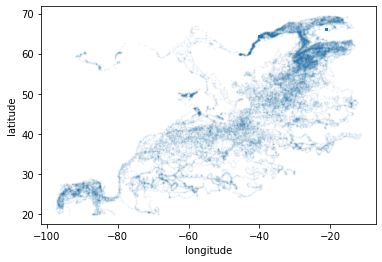

In [9]:
df.plot.scatter(x="longitude", y="latitude", alpha=0.05, s=1);

In [10]:
from lagtrajclust.visualisation import polygonise_h3s

In [11]:
abs(df["latitude"].diff() * 111e3).describe()

count    2.829800e+04
mean     3.437498e+04
std      8.332633e+04
min      0.000000e+00
25%      7.208340e+03
50%      1.952512e+04
75%      4.203148e+04
max      4.283019e+06
Name: latitude, dtype: float64

<AxesSubplot:>

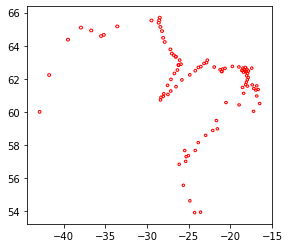

In [16]:
fig, ax = plt.subplots(1, 1)
polygonise_h3s(h3_series_to_h3_parent(
    df.dropna().reset_index()["h3r15"],
    resolution=5,
)).iloc[0:100].reset_index()[0].plot(ax=ax, edgecolor='red', facecolor="none")

## Coarsen daadd_max_res_h3_columnnd transform

We coarsen (from the highest-resolution data), and transform to a series of lists of h3s without subsequent dupes.

In [13]:
from lagtrajclust.h3_trafo import find_max_needed_h3_resolution

In [14]:
find_max_needed_h3_resolution(df)

5

In [15]:
h3_working_resolution = 0

In [15]:
%%time

h3_series = h3_series_to_h3_parent(df["h3r15"], resolution=h3_working_resolution)

h3_sequences = h3_series_to_series_of_h3_sequences(h3_series)

h3_sequences = remove_subsequent_identical_elements(h3_sequences)

NameError: name 'h3_working_resolution' is not defined

In [ ]:
h3_series

In [ ]:
display(h3_sequences)

Check length distribution

In [ ]:
h3_lengths = h3_sequences.apply(len)
bin_number = int(np.log(5 * h3_lengths.max()))
h3_lengths.plot.hist(bins=bin_number);

In [ ]:
h3_num_unique = h3_sequences.apply(set).apply(len)
bin_number = int(np.log(5 * h3_num_unique.max()))
h3_num_unique.plot.hist(bins=bin_number);

## Do a clustering

In [ ]:
%%time

# cluster_ids = dbscan_with_edist_metric(h3_sequences, eps=0.3)
cluster_ids = optics_with_edist_metric(h3_sequences, max_eps=0.4, normalize=True)

In [ ]:
cluster_ids.plot()

In [ ]:
cluster_ids.plot.hist(bins=len(cluster_ids.unique()));

In [ ]:
df

In [ ]:
from functools import reduce
from operator import add

In [ ]:
_df = df.join(cluster_ids.rename("cluster_ids"))
_df

In [ ]:
ax = df.join(cluster_ids.rename("cluster_ids")).plot.scatter(
    x="longitude", y="latitude", 
    c="cluster_ids", cmap="tab20c",
    s=1, alpha=0.8,
    figsize=(16, 12),
);
polygonise_h3s(reduce(add, h3_sequences)).plot(ax=ax, edgecolor='red', facecolor="none");

In [ ]:
from math import ceil, floor

In [ ]:
num_clusters = len(cluster_ids.unique())
cols, rows = int(num_clusters ** 0.5), num_clusters // floor(num_clusters ** 0.5)

fig, ax = plt.subplots(cols, rows, figsize=(8 * cols, 4 * rows))
for cid, _ax in zip(sorted(cluster_ids.unique()), ax.flatten()):
    _df[_df["cluster_ids"] == cid].reset_index().plot.scatter(
        x="longitude", y="latitude", 
        c="traj", cmap="viridis",
        s=1, alpha=0.6, ax=_ax,
        colorbar=False,        
    );
    _ax.set_title(f"cluster {cid}")
    polygonise_h3s(list(set(reduce(add, h3_sequences)))).plot(ax=_ax, edgecolor='gray', facecolor="none");
    polygonise_h3s(list(set(reduce(add, h3_sequences[cluster_ids == cid])))).plot(ax=_ax, edgecolor='red', facecolor="none");

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from nltk.metrics.distance import edit_distance
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

labels = [
    'Tacos',
    'Tacoes',
    'Tomatos',
    'Tomatoes',
    'Beef',
    'Beer',
    'Steak',
    'Pig',
    'Twig'
]

def d(coord):
    i, j = coord
    return edit_distance(labels[i], labels[j])

coords = np.triu_indices(len(labels), 1)
result = np.apply_along_axis(d, 0, coords)
clust = linkage(result)

dend = dendrogram(clust, labels=labels, leaf_font_size=8)
plt.show()

In [ ]:
def d(coord):
    i, j = coord
    return edit_distance(h3_sequences.iloc[labels[i]], h3_sequences.iloc[labels[j]])

In [ ]:
%%time

labels = np.random.choice(np.arange(len(h3_sequences)), size=(1_000, ), replace=False)

In [ ]:
%%time

coords = np.triu_indices(len(labels), 1)

In [ ]:
%%time

result = np.apply_along_axis(d, 0, coords)

In [ ]:
%%time

clust = linkage(result)

In [ ]:
clust.shape

In [ ]:
dendrogram?

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
dend = dendrogram(clust, labels=labels, leaf_font_size=8, ax=ax, p=10, truncate_mode='lastp')
plt.show()

In [ ]:
ind = 323; ax = df.loc[ind].plot(x="longitude", y="latitude", label=ind)
ind = 92; df.loc[ind].plot(x="longitude", y="latitude", label=ind, ax=ax)
ind = 143; df.loc[ind].plot(x="longitude", y="latitude", label=ind, ax=ax)
# ind = 729; df.loc[ind].plot(x="longitude", y="latitude", label=ind, ax=ax)